In [1]:
import numpy as np 
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt 

class PINN(nn.Module):
    def __init__(self,hidden_dimensions: list = [2,128,1],activation_fn = nn.Tanh()):
        super(PINN,self).__init__()
        self.layers = nn.ModuleList([])
        self.activation_fn = activation_fn
        for i in range(len(hidden_dimensions)-1):
            self.layers.append(nn.Linear(hidden_dimensions[i],hidden_dimensions[i+1]))
            if(i<len(hidden_dimensions)-2): #no activation for final layer 
                self.layers.append(self.activation_fn)
        
        self.layers = nn.Sequential(*self.layers)

    def forward(self,x,t):
        #print_shape(x)
        #print_shape(t)
        x_stack = torch.cat([x,t],dim=1)
        return self.layers(x_stack)

In [2]:
#order is order of differentiation
def df(output: torch.Tensor, input_var: torch.Tensor, order: int = 1) -> torch.Tensor:
    """Compute neural network derivative with respect to input features using PyTorch autograd engine"""
    df_value = output      # <-- we directly take the output of the NN
    for _ in range(order):
        df_value = torch.autograd.grad(
            df_value,
            input_var,
            grad_outputs=torch.ones_like(input_var),
            create_graph=True,
            retain_graph=True,
        )[0]
    return df_value

def dfdt(model: PINN, x: torch.Tensor, t: torch.Tensor, order: int = 1):
    """Derivative with respect to the time variable of arbitrary order"""
    f_value = model(x, t)
    return df(f_value, t, order=order)

def dfdx(model: PINN, x: torch.Tensor, t: torch.Tensor, order: int = 1):
    """Derivative with respect to the spatial variable of arbitrary order"""
    f_value = model(x, t)
    return df(f_value, x, order=order)

Add in initial conditions. We have three initial conditions 

\begin{align*}
    g_L(t)&=u(-1,t)=\exp(-\epsilon t)\cos(-1)+4\exp(-16\epsilon t)\cos(-4)+16\exp(-256\epsilon t)\cos(-16),\quad \epsilon=0.1\\
    g_R(t)&=u(1,t)=\exp(-\epsilon t)\cos(1)+4\exp(-16\epsilon t)\cos(4)+16\exp(-256\epsilon t)\cos(16),\quad \epsilon=0.1\\
    \eta(x)&=u(x,0)=\cos(x)+4\cos(4x)+16\cos(16x)
\end{align*}

In [43]:
def boundary_conditions_g(x: np.array,t: np.array, epsilon: float = 0.1) -> np.array:
    if(x[0]==-1):
        print("found left boundary")
        g = np.exp(-epsilon*t)*np.cos(-1)+4*np.exp(-16*epsilon*t)*np.cos(-4) + 16*np.exp(-256*epsilon*t)*np.cos(-16)
    elif(x[0]==1):
        print("found right boundary")
        g = np.exp(-epsilon*t)*np.cos(1) + 4*np.exp(-16*epsilon*t)*np.cos(4) + 16*np.exp(-256*epsilon*t)*np.cos(16)
    else:
        raise NotImplementedError(f"boundary_conditions_g received wrong boundary grid...x[0]={x[0]}")
    return g 

def boundary_conditions_eta(x: np.array, t: np.array) -> np.array:
    assert t[0]==0.0, f"called eta boundary condition for wrong t value: {t} (should be 0.0)"
    eta = np.cos(x)+4*np.cos(4*x) + 16*np.cos(16*x)
    return eta


#t_grid = np.linspace(0,1,10)
#x_grid = np.linspace(-1,1,10)
#gL = boundary_conditions_g(-1,t=t_grid)
#gR = boundary_conditions_g(1,t=t_grid)
#eta = boundary_conditions_eta(x_grid,t=0.0)


In [4]:
def u_fun(x,t): #this is exactly as in matlab, but it seems the expression doesn't match what is stated in overleaf for boundary-conditions
    alpha = [1, 4, 16]
    N = 3
    a = 1
    b = 0
    epsilon = 0.1
    u = 0.0
    for n in range(N):
        #first = torch.exp(-epsilon*alpha[n]**2*T)
        #second = a*torch.cos(alpha[n]*X)
        #third = b*torch.sin(alpha[n]*X)
        #print(first.shape, second.shape, third.shape)
        u += torch.exp(-epsilon*alpha[n]**2*t)*(a*torch.cos(alpha[n]*x) + b*torch.sin(alpha[n]*x))
    return u

_x = 1.0
_t = 1.0
test_x = torch.Tensor([_x])
test_t = torch.Tensor([_t])
print(u_fun(test_x,test_t))
#print(boundary_conditions_g(np.array([_x]),np.array([_t])))


tensor([0.3569])


#todo: try another diffEq, simpler with boundary conds 

solve
$$\frac{\partial^2 f}{\partial x^2} = \frac{1}{C} \frac{\partial^2 f}{\partial t^2}$$

st $f(x,t=0) = \frac{1}{2}\sin(2\pi x)$ and boundaries $f(x_0,t)=f(x_1,t)=0$ and initial condition $\frac{\partial f(x, t)}{\partial t} \bigg\rvert_{t=0}$

$$\left( \frac{\partial^2 f}{\partial x^2} - \frac{1}{C} \frac{\partial^2 f}{\partial t^2} \right)^2 $$

In [5]:
device="cpu"
x_domain = [0.0, 1.0]; n_points_x = 100
t_domain = [0.0, 1.0]; n_points_t = 150
x_idx = torch.linspace(x_domain[0], x_domain[1], steps=n_points_x, requires_grad=True)
t_idx = torch.linspace(t_domain[0], t_domain[1], steps=n_points_t, requires_grad=True)
grids = torch.meshgrid(x_idx, t_idx, indexing="ij")
x_idx, t_idx = x_idx.reshape(-1, 1).to(device), t_idx.reshape(-1, 1).to(device)
x, t = grids[0].flatten().reshape(-1, 1).to(device), grids[1].flatten().reshape(-1, 1).to(device)


In [6]:
boundary_x0 = torch.ones_like(t_idx,requires_grad=True) * x[0] #left boundary
boundary_x1 = torch.ones_like(t_idx,requires_grad=True) * x[-1] #right boundary

def initial_condition(x) -> torch.Tensor:
    return torch.sin(2*np.pi*x).reshape(-1,1)*0.5

f_initial = initial_condition(x_idx)
loss = nn.MSELoss()


Build a big solver class

In [9]:
from torch.optim import Adam 
from tqdm import tqdm


class ODESolver:
    def __init__(self,hidden_dimensions: list=None,
                 activation_fn=nn.Tanh(),
                 t_min = 0, 
                 t_max = 1,
                 N_time_points: int = 100,
                 N_spatial_points: int = 100, 
                 x_min = -1, 
                 x_max=1, 
                 verbose = False
                ):
        """
        arguments: self explanatory
            differentials: list of booleans encoding truth value for needed dx, dt, dxx, dtt.
            differential_equation: a lambda function calculating the network output and ground truth argument for the loss-criterion
        """
        #device = torch.device("cuda") if torch.cuda_is_available() else torch.device("cpu")
        self.verbose = verbose
        self.model = PINN(hidden_dimensions=hidden_dimensions,activation_fn=activation_fn)#PINN(hidden_dimensions=hidden_dimensions,activation_fn=activation_fn)
        

        # Create grid over the whole domain
        x_idx = torch.linspace(x_min,x_max,steps=N_spatial_points,requires_grad=True)
        t_idx = torch.linspace(t_min,t_max,steps=N_time_points,requires_grad=True)
        grids = torch.meshgrid(x_idx,t_idx,indexing="ij")
        self.x_idx, self.t_idx = x_idx.reshape(-1,1), t_idx.reshape(-1,1)

        #save everything we need to class
        self.x, self.t = grids[0].flatten().reshape(-1,1), grids[1].flatten().reshape(-1,1)
        self.t_initial = torch.ones_like(x_idx,requires_grad=True)*t[0]
        self.t_initial = self.t_initial.reshape(-1,1)
        self.y_initial = initial_condition(self.x_idx) #should be made a function handle 
        self.boundary_x0 = torch.ones_like(self.t_idx,requires_grad=True)*self.x[0]
        self.boundary_x1 = torch.ones_like(self.t_idx,requires_grad=True)*self.x[-1]
        
        #todo: 
        #add boundary_y0 and boundary_y1 (currently working with initial condition f(x0,t)=f(x1,t)=0, but it should have rhs)
        #also note that we in this case have added an initial condition on f, but ALSO on dfdt(t=0)
                
        #instantiate loss criterion: 
        self.criterion = torch.nn.MSELoss()
        
        #setup optimization
        self.optimizer = Adam(self.model.parameters(),lr=1e-2, betas=(0.9,0.999), weight_decay=0.0, amsgrad=False)
        

    def predict_compute_losses(self):
        pred_x0 = self.model(x=self.boundary_x0,t=self.t_idx) #predict at lower boundary
        pred_x1 = self.model(x=self.boundary_x1,t=self.t_idx)
        
        #the way I'd rather want to do it later
        #initial_loss = self.criterion(pred_initial - self.y_initial)
        #initial_loss_df = self.criterion(dfdt(self.model,self.x_idx,self.t_initial,order=1))
        #pde_loss = self.criterion(df)
        
        #this is the magic - but realize it is almost exactly what you did earlier. Recheck your loss, recheck your dimensions. Your implementation seems fine
        initial_loss_f = self.criterion(self.model(self.x_idx,self.t_initial),self.y_initial) #get mse-loss f(t=0( between initial condition anx y predicted at initial  
        dfdt_ = dfdt(self.model,self.x_idx,self.t_initial,order=1) #needed for "pde loss"
        initial_loss_df = self.criterion(dfdt_,torch.zeros_like(dfdt_))  #condition says it should be zero, so form a loss based on that
        C=1.0 #constant for specific pde
        pde_loss = self.criterion(dfdx(self.model,self.x,self.t,order=2),(1/C**2)*dfdt(self.model,self.x,self.t,order=2)) #pde-loss is basically left hand side minus right hand side, so either set target zero, or set output = lhs, target = rhs
        loss = pde_loss + initial_loss_df + initial_loss_f + self.criterion(pred_x0,torch.zeros_like(pred_x0)) + self.criterion(pred_x1,torch.zeros_like(pred_x1)) #boundary conditions in this case are zero :)
        
        #this stuff also worked  if it is nicer to read:
        #initial_loss_f = self.model(self.x_idx,self.t_initial) - self.y_initial
        #initial_loss_df = dfdt(self.model,self.x_idx,self.t_initial,order=1)
        #C = 1.0
        #pde_loss = dfdx(self.model,self.x,self.t,order=2) - (1/C**2) * dfdt(self.model,self.x,self.t,order=2)
        #loss = \
        #pde_loss.pow(2).mean() + \
        #pred_x0.pow(2).mean() + \
        #pred_x1.pow(2).mean() + \
        #initial_loss_f.pow(2).mean() + \
        #initial_loss_df.pow(2).mean()

        return loss

    
    def train(self,nepochs=5000):
        self.model.train()
        loss_holder = []
        pbar = tqdm(range(nepochs))
        for i in pbar:
            loss = self.predict_compute_losses()
            self.optimizer.zero_grad()
            if(i%5==0):
                pbar.set_description_str(f"epoch {i} | loss: {loss.item():.4f}")
            loss.backward(retain_graph=True)
            self.optimizer.step()
            loss_holder.append(loss.item())
        return loss_holder
    
    
    def predict(self,x=None,t=None):
        self.model.eval()
        #X = torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T
        if(x==None or t==None):
            y_pred = self.model(x=self.x,t=self.t)
        else:
            y_pred = self.model(x,t)
        #y_pred = y_pred.reshape(len(x),len(t)).detach().cpu().numpy()
        self.model.train()
        return y_pred
        
    
import inspect
def print_shape(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    str_var = [var_name for var_name, var_val in callers_local_vars if var_val is var]
    print(f"{str_var[0]} shape: {str(var.shape)}")


model = ODESolver(hidden_dimensions=[2,20,20,20,20,20,1],
                  activation_fn=nn.Tanh(),
                  N_spatial_points=100,
                  N_time_points = 150,
                  t_min = 0.0,
                  t_max = 1.0,
                  x_min = 0.0,
                  x_max = 1.0,
                  verbose=False) #

N_EPOCHS = 3000
losses = model.train(N_EPOCHS)



  0%|          | 0/3000 [00:00<?, ?it/s]

epoch 2995 | loss: 0.0035: 100%|██████████| 3000/3000 [05:52<00:00,  8.51it/s]


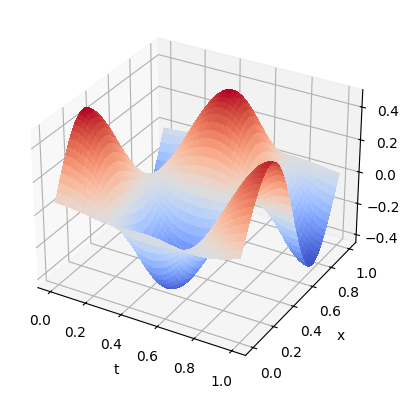

In [59]:
from matplotlib import cm
y = model.predict()
y_np = y.reshape([100,-1]).to("cpu").detach().numpy()

# Plot
%matplotlib inline
X, Y = np.meshgrid(np.linspace(0, 1, 150), np.linspace(0, 1, 100))
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(X, Y, y_np, linewidth=0, antialiased=False, cmap=cm.coolwarm,)
ax.set_xlabel("t"), ax.set_ylabel("x"), ax.set_zlabel("f")
plt.show()

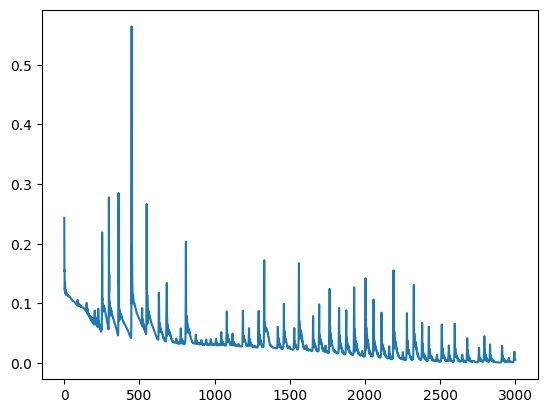

In [60]:
plt.plot(losses)